In [1]:
# TODO 
# IMPROVE SUBJECT DF CREATION !!!!
# REMOVE NON NEEDED VISUALISATIONS !!!!!!!
# THE ZERO CENTRING NEEDS TO BE DONE BASED ON INDIVIDUAL BURSTS AND NOT ALL BURSTS !!!!!!!!

# ONLY 2 MUSCLES CLASSIFICATION WITHOUT R+L!!!!!

In [2]:
# Installation of BioSignalsNotebooks
# %pip install biosignalsnotebooks
# %pip install tqdm

In [3]:
# Imports
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
# import plotly.graph_objects as go

# Tensorflow Model
import tensorflow as tf
from keras import Sequential
from keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.src.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import InputLayer, Conv1D, LeakyReLU, MaxPooling1D, LSTM

# Model Metrics
import seaborn as sn
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

# Pickle
# import pickle
# from dill import dumps, loads

## Creating the sEMG Dataframes from the CSV files

In [4]:
# Function to create a dataframe to store the data of every subject across all trials 
def subject_df_creator(subject_id, muscles_of_interest):
    trials_dfs_list = []
    output_msg=[]
    for trial_number in tqdm(range(1, 51), desc=f"Concatenating trial Files for Subject AB{subject_id}"):
        filename = f"5362627/AB{subject_id}/AB{subject_id}/Raw/AB{subject_id}_Circuit_0{trial_number:02d}_raw.csv"
        if not os.path.exists(filename):  # Check if the file exists
            output_msg.append(f"0{trial_number:02d}")
            continue
        df_trial = pd.read_csv(filename)

        df_trial_combined = pd.DataFrame()

        # Concatenate 'Right_' and 'Left_' values for each muscle of interest
        df_trial_combined[muscles_of_interest[0]] = pd.concat([df_trial['Right_'+muscles_of_interest[0]], df_trial['Left_'+muscles_of_interest[0]]], ignore_index=True)
        df_trial_combined[muscles_of_interest[1]] = pd.concat([df_trial['Right_'+muscles_of_interest[1]], df_trial['Left_'+muscles_of_interest[1]]], ignore_index=True)

        trials_dfs_list.append(df_trial_combined)

    # Concatenate all DataFrames in the list along the rows axis
    merged_df = pd.concat(trials_dfs_list, ignore_index=True)
    if output_msg:
        print(f"{len(output_msg)} Files do not exist:", output_msg)
    return merged_df

In [5]:
# Defining important lists
subjects = ["156", "185", "188", "186", "189", "190", "191", "192", "193", "194"]
muscles = ['MG', 'SOL']

In [6]:
# Creating dataframes to save subject-specific data
df_subject_156 = subject_df_creator("156", muscles)
df_subject_185 = subject_df_creator("185", muscles)
df_subject_186 = subject_df_creator("186", muscles)
df_subject_188 = subject_df_creator("188", muscles)
df_subject_189 = subject_df_creator("189", muscles)
df_subject_190 = subject_df_creator("190", muscles)
df_subject_191 = subject_df_creator("191", muscles)
df_subject_192 = subject_df_creator("192", muscles)
df_subject_193 = subject_df_creator("193", muscles)
df_subject_194 = subject_df_creator("194", muscles)
# IMPROVE !!!!!!!!!!!!!!!!!!!!!!

Concatenating trial Files for Subject AB156:   0%|          | 0/50 [00:00<?, ?it/s]

Concatenating trial Files for Subject AB185:   0%|          | 0/50 [00:00<?, ?it/s]

Concatenating trial Files for Subject AB186:   0%|          | 0/50 [00:00<?, ?it/s]

6 Files do not exist: ['005', '010', '020', '025', '035', '040']


Concatenating trial Files for Subject AB188:   0%|          | 0/50 [00:00<?, ?it/s]

10 Files do not exist: ['041', '042', '043', '044', '045', '046', '047', '048', '049', '050']


Concatenating trial Files for Subject AB189:   0%|          | 0/50 [00:00<?, ?it/s]

1 Files do not exist: ['050']


Concatenating trial Files for Subject AB190:   0%|          | 0/50 [00:00<?, ?it/s]

1 Files do not exist: ['045']


Concatenating trial Files for Subject AB191:   0%|          | 0/50 [00:00<?, ?it/s]

6 Files do not exist: ['005', '010', '020', '025', '035', '040']


Concatenating trial Files for Subject AB192:   0%|          | 0/50 [00:00<?, ?it/s]

2 Files do not exist: ['004', '022']


Concatenating trial Files for Subject AB193:   0%|          | 0/50 [00:00<?, ?it/s]

Concatenating trial Files for Subject AB194:   0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
# Merging all the subject dataframes into one
list_of_all_subjects_dfs = [df_subject_156 , df_subject_185, df_subject_188 , df_subject_186, df_subject_189,
                            df_subject_190, df_subject_191, df_subject_192, df_subject_193, df_subject_194]
df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [8]:
df_all_subjects

,MG,SOL
0,-0.078660,-0.077287
1,-0.069810,-0.068132
2,-0.055314,-0.057298
3,-0.051194,-0.052110
4,-0.048295,-0.049363
...,...,...
23351875,-0.063249,-0.095598
23351876,-0.061875,-0.082628
23351877,-0.059892,-0.076371
23351878,-0.061112,-0.072251


## EMG Visualisation 

In [9]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x=df_all_subjects.index/1000, y=df_all_subjects['Right_TA'][60000:90000]))
# fig1.update_layout( title="sEMG Signal: Sitting Vs Contraction Bursts Vs Rest", xaxis_title="Time (s)",
#                     yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4),
#                     autosize=False, width=800, height=300)
# # plotting
# fig1.show()

## EMG Analysis

In [10]:
# Studying mean, sigma and variance of the 2 Muscles
df_analysis = pd.DataFrame()
df_analysis['Mean'] = df_all_subjects.mean()
df_analysis['Std'] = df_all_subjects.std()
df_analysis['Var'] = df_all_subjects.var()
df_analysis

,Mean,Std,Var
MG,-0.067019,0.046308,0.002144
SOL,-0.078862,0.053928,0.002908


## Burst Detection

In [11]:
# Saving the detected bursts for every muscle 
sr = 1000 # sample rate = 1000Hz
sl = 20 # smooth level (Size of sliding window used during the moving average process) #used to be 40
th = 10 # threshold (To cover activation)

# Initializing lists
detected_bursts_MG = [] ; detected_bursts_SOL= []

pbar = tqdm(total=len(muscles)*len(list_of_all_subjects_dfs), desc="All Subjects Burst Detection Progress", unit= "Muscle")
for df_subject in list_of_all_subjects_dfs: ################# !!!!!!!!!!!!!!!!!!!!!!!!!!
    ## MG
    detected_bursts_MG.append(bsnb.detect_emg_activations(emg_signal=df_subject['MG'], sample_rate=sr, smooth_level=sl,
                                                          threshold_level=th, time_units=True, device='CH0', plot_result= False))
    pbar.update(1)
    ## SOL
    detected_bursts_SOL.append(bsnb.detect_emg_activations(emg_signal=df_subject['SOL'], sample_rate=sr, smooth_level=sl,
                                                           threshold_level=th, time_units=True, device='CH0', plot_result= False))
    pbar.update(1)

All Subjects Burst Detection Progress:   0%|          | 0/20 [00:00<?, ?Muscle/s]

In [12]:
# pd.DataFrame(detected_bursts_SOL[0:3][:10]).transpose()

## Detected Bursts Visualisation

In [13]:
# # Visualising the EMG Burst Detection for SOL
# plot_duration = 40000 # time in milliseconds
# bsnb.detect_emg_activations(emg_signal = df_all_subjects['SOL'][:plot_duration], sample_rate = sr, smooth_level=sl, threshold_level=th, time_units=True, device='CH0', plot_result= True)
# print('')

In [14]:
# # Visualizing First Activations -> SEE CAPTURED WINDOW WITH RESPECT OF IDENTIFIED ACTIVATION
# duration = 8000
# shift = 2000
# number_bursts_to_plot = 1
# 
# plt.rcParams["figure.figsize"] = (10,5)
# fig = plt.figure()
# 
# plt.plot(df_all_subjects['Right_TA'][:duration], color="cornflowerblue")
# for i in range(number_bursts_to_plot): # Plot first N bursts
#     plt.axvline(detected_bursts_right_TA[0][i]*1000,color='red', label="Detected Burst Region") # ONSET VERTICAL LINE
#     plt.axvline(detected_bursts_right_TA[1][i]*1000,color='red') # OFFSET VERTICAL LINE
#     plt.axvline(detected_bursts_right_TA[0][i]*1000+400,color='black', label="Onset Window (500ms)") # ONSET VERTICAL LINE CORRECTED (START WINDOW)
#     plt.axvline(detected_bursts_right_TA[0][i]*1000-100,color='black') # VERTICAL LINE (END WINDOW)
#     
# plt.legend(loc="upper left")
# plt.xlim(shift,duration)
# plt.grid()
# plt.xlabel('Time (ms)', fontsize=10)
# plt.ylabel('sEMG Intensity (V)', fontsize=10)
# 
# # plt.savefig("Window.png")

In [15]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x = df_all_subjects.index/1000 , y=df_all_subjects['Left_TA'][:10000]))
# 
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detected burst and corrected onset window",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)", margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# fig1.add_vrect(x0=detected_bursts_right_TA[0][0], x1=detected_bursts_left_TA[1][0], row="all", col=1,
#                annotation_text="Detected Burst", annotation_position="top right", fillcolor="gray",
#                opacity=0.25, line_width=0)
# 
# fig1.add_vline(x=detected_bursts_left_TA[0][0]+0.4,line_width=1.5, line_dash="dot", line_color="red")
# fig1.add_vline(x=detected_bursts_left_TA[0][0]-0.1,line_width=1.5, line_dash="dot", line_color="red",
#                annotation_text="Onset Window",annotation_position="bottom right")
# 
# # fig1.update_xaxes(range=[7.5, 20000/1000])
# # fig1.update_yaxes(range=[-2, 2])
# fig1.update_layout(autosize=False, width=800, height=300)
# # plotting
# fig1.show()

In [16]:
# # adding figures and traces
# fig1 = go.Figure()
# fig1.add_trace(go.Scatter(x= df_all_subjects.index/1000, y=df_all_subjects['Right_TA']))
# # formatting the plot
# fig1.update_layout(autosize=True, title="sEMG Signal: Detection of Activation Bursts",
#                    xaxis_title="Time (s)", yaxis_title="sEMG Activity (V)",
#                    margin=dict(l=50, r=50, b=50, t=50, pad=4))
# 
# for i in range(len(detected_bursts_right_TA[0])):
#     fig1.add_vrect(x0=detected_bursts_right_TA[0][i], x1=detected_bursts_right_TA[1][i], row="all", col=1,
#                    annotation_text="Detected Burst", annotation_position="top right",
#                    fillcolor="black", opacity=0.25, line_width=0)
# 
# # fig1.update_xaxes(range=[30, 60])
# fig1.update_layout(autosize=False, width=800, height=300)
# # plotting
# fig1.show()

## Detected Bursts Analysis 

In [17]:
# Defining Variables to store the total length of every muscle 
tot_bursts_MG = 0
tot_bursts_SOL= 0

# Calculating the total number of bursts per muscle
for subject_idx in range(len(detected_bursts_MG)):
    tot_bursts_MG += len(detected_bursts_MG[subject_idx][0])
    tot_bursts_SOL+= len(detected_bursts_SOL[subject_idx][0])

In [18]:
# Printing the total number of bursts per muscle
print("- Number of Identified Bursts:\n",
      "   MG: ", tot_bursts_MG, "\n","   SOL:", tot_bursts_SOL)

- Number of Identified Bursts:
    MG:  6683 
    SOL: 5623


In [19]:
# Lists to store average burst length per muscle for all subjects
average_burst_lengths_MG = []
average_burst_lengths_SOL= []

# Calculating average burst length per muscle
for subject in range(len(list_of_all_subjects_dfs)):
    ## MG
    average_burst_lengths_MG.append(np.mean(np.array(detected_bursts_MG[subject][1])-np.array(detected_bursts_MG[subject][0]))*1000)
    ## SOL
    average_burst_lengths_SOL.append(np.mean(np.array(detected_bursts_SOL[subject][1])-np.array(detected_bursts_SOL[subject][0]))*1000)

In [20]:
# Printing average burst length per muscle
print("- Avg. Length:\n",
      "   Right MG:\t", round(np.mean(average_burst_lengths_MG), 2), "ms", "\n", "   Right SOL:\t", round(np.mean(average_burst_lengths_SOL), 2), "ms")

- Avg. Length:
    Right MG:	 426.02 ms 
    Right SOL:	 625.34 ms


In [21]:
# TODO :  REDO THIS MY WAY 
# Longest muscle bursts 
longest_pulses = {}

for muscle in muscles:
    bursts_variable_name = f"detected_bursts_{muscle}"
    bursts = eval(bursts_variable_name)  # Use with caution; assumes variable names follow a consistent naming convention
    longest_pulse = 0  # Initialize with zero to handle empty data

    for i in range(len(bursts)):
        pulse_durations = np.array(bursts[i][1]) - np.array(bursts[i][0])
        current_longest_pulse = max(pulse_durations, default=0)  # Use default=0 to handle empty arrays
        if current_longest_pulse > longest_pulse:
            longest_pulse = current_longest_pulse

    longest_pulses[f"{muscle}"] = longest_pulse

In [22]:
# Print the longest pulse for each muscle and side
for key, value in longest_pulses.items():
    print(f"Longest pulse for {key}:\t {round(value,2)} seconds")

Longest pulse for MG:	 2.52 seconds
Longest pulse for SOL:	 12.86 seconds


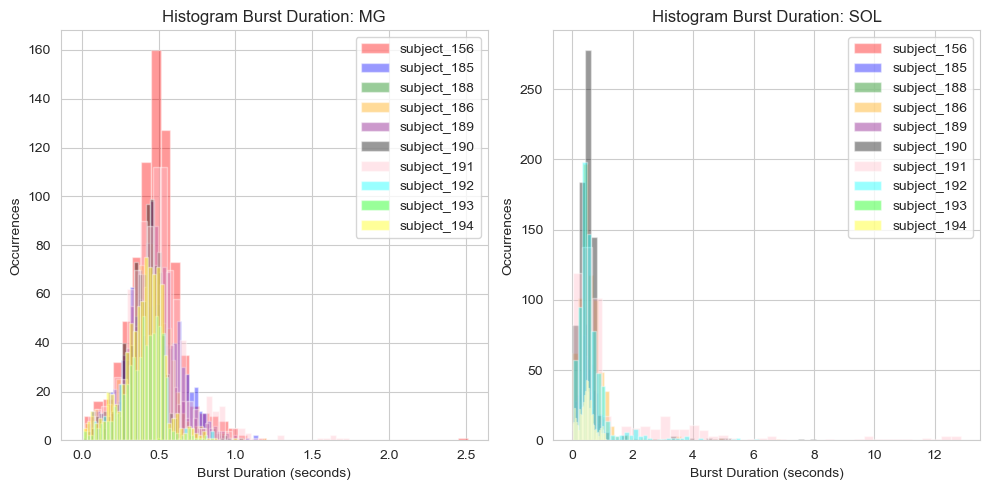

In [24]:
# Adjust subplot indexing
f, a = plt.subplots(1, 2)
f.set_size_inches(10, 5)
a = a.ravel()

colors = ['red', 'blue', 'green', 'orange', 'purple', 'black', 'pink', 'cyan', 'lime', 'yellow']

for subject_idx, subject in enumerate(subjects):
    subject = "subject_" + subject

    a[0].hist(np.array(detected_bursts_MG[subject_idx][1]) - np.array(detected_bursts_MG[subject_idx][0]), bins=40, alpha=0.4, label=subject, color=colors[subject_idx])
    a[1].hist(np.array(detected_bursts_SOL[subject_idx][1]) - np.array(detected_bursts_SOL[subject_idx][0]), bins=40, alpha=0.4, label=subject, color=colors[subject_idx])

# Set legends, titles, and labels for each subplot
for muscle_idx, muscle in enumerate(muscles):
    a[muscle_idx].legend(loc='upper right')
    a[muscle_idx].set_title('Histogram Burst Duration: ' + muscle)
    a[muscle_idx].set_xlabel("Burst Duration (seconds)")
    a[muscle_idx].set_ylabel("Occurrences")

plt.tight_layout()
plt.show()

## Leave one out: Separating a Subject

In [25]:
leave_one_out = 2 # Specify which one to leave out

In [26]:
# Saving the LOO Bursts
loo_detected_bursts_MG = [detected_bursts_MG.pop(leave_one_out)]
loo_detected_bursts_SOL= [detected_bursts_SOL.pop(leave_one_out)]

In [27]:
# Saving the LOO EMG signal
loo_emg_signal_MG  = list(list_of_all_subjects_dfs[leave_one_out]['MG'])
loo_emg_signal_SOL = list(list_of_all_subjects_dfs[leave_one_out]['SOL'])

In [28]:
# Removing the LOO from the training
del list_of_all_subjects_dfs[leave_one_out]
df_all_subjects = pd.concat(list_of_all_subjects_dfs, ignore_index=True)

In [29]:
# Verifying the LOO process
print(f"Subject AB{subjects[leave_one_out]} was excluded from the training!\n"
      f"{len(list_of_all_subjects_dfs)} subjects remaining for training!")

Subject AB188 was excluded from the training!
9 subjects remaining for training!


# Extracting Bursts

### Method: Preserving Onset and Window = 300ms

In [30]:
def extract_burst_windows(muscle_emg_signal, onset_list, window_size, left_shift_value, muscle_name):
    sampling_rate = 1000
    all_subjects_burst_samples = []
    for subject_index in tqdm(range(len(onset_list)), desc=f"Extracting Bursts for {muscle_name}"):
        current_subject_bursts = []
        ii = -1
        for onset in onset_list[subject_index][0]:
            ii += 1
            onset_ms = int(onset * sampling_rate) - left_shift_value
            current_sample_window = []
            if onset != onset_list[subject_index][0][-1]:
                if (onset_ms + window_size) < (onset_list[subject_index][0][ii + 1] * 1000):
                    for time_step in range(window_size):
                        current_sample_window.append(muscle_emg_signal[onset_ms + time_step])
            else:
                for time_step in range(window_size):
                    current_sample_window.append(muscle_emg_signal[onset_ms + time_step])

            if current_sample_window:
                current_sample_window -= np.mean(current_sample_window)
                current_subject_bursts.append(current_sample_window)
        all_subjects_burst_samples.append(current_subject_bursts)
    return all_subjects_burst_samples

In [31]:
window = 300 # in ms (total window size)
left_shift = 50 # in ms (left shift from detected onset). See detected onset on the vertical red lines in the plots above

fixed_bursts_MG = extract_burst_windows(df_all_subjects['MG'], detected_bursts_MG, window, left_shift, 'MG')
fixed_bursts_SOL = extract_burst_windows(df_all_subjects['SOL'], detected_bursts_SOL, window, left_shift, 'SOL')

Extracting Bursts for MG:   0%|          | 0/9 [00:00<?, ?it/s]

Extracting Bursts for SOL:   0%|          | 0/9 [00:00<?, ?it/s]

In [68]:
## TODO REDO THE REST LIKE THIS  
from tabulate import tabulate

# Create a list of lists containing the data
data = []
for i, subject in enumerate(subjects):
    if i != leave_one_out:
        data.append([subject, len(fixed_bursts_MG[i]), len(fixed_bursts_SOL[i])])

# Print the table
print("Number of Muscle Bursts Per Muscle Per Subject (Fixed Window):\n")
print(tabulate(data, headers=["Subject", "MG Bursts", "SOL Bursts"]))

IndexError: list index out of range

In [33]:
print("Number of Muscle Bursts Per Muscle Per Subject (Fixed Window):\n",
      "   Subjects:", [subjects[i] for i in range(len(subjects)) if i != leave_one_out], "\n",
      "   MG:\t\t", [len(lst) for lst in fixed_bursts_MG], "\n",
      "   SOL:\t", [len(lst) for lst in fixed_bursts_SOL], "\n")

Number of Muscle Bursts Per Muscle Per Subject (Fixed Window):
    Subjects: ['156', '185', '186', '189', '190', '191', '192', '193', '194'] 
    MG:		 [759, 945, 726, 973, 851, 911, 652, 1, 818] 
    SOL:	 [296, 820, 690, 998, 737, 498, 726, 1, 660] 


In [34]:
# Extracting the LOO 300-fixed bursts
loo_fixed_bursts_MG = extract_burst_windows(loo_emg_signal_MG, loo_detected_bursts_MG, window, left_shift, 'Leave one Out: MG')[0]
loo_fixed_bursts_SOL = extract_burst_windows(loo_emg_signal_SOL, loo_detected_bursts_SOL, window, left_shift, 'Leave one Out: SOL')[0]

Extracting Bursts for Leave one Out: MG:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting Bursts for Leave one Out: SOL:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
print("Leave One Out Subject's Number of Muscle Bursts (Fixed Window):\n",
      "   Right MG:\t", len(loo_fixed_bursts_MG), "\n",
      "   Right SOL:\t", len(loo_fixed_bursts_SOL))

Leave One Out Subject's Number of Muscle Bursts (Fixed Window):
    Right MG:	 31 
    Right SOL:	 166


## Saving Leave One Out as TFRecord

In [36]:
loo_emg_series_complete = [loo_fixed_bursts_MG, loo_fixed_bursts_SOL]

muscle_groups = len(loo_emg_series_complete)

with tf.io.TFRecordWriter('tfrecords/leave_one_out.tfrecord') as tfrecord:
    for emg_muscle in tqdm(range(muscle_groups), desc="Extracting dataset to TFRecords"):
        for sample in loo_emg_series_complete[emg_muscle]:
            # Prepare the features for TFRecord
            features = {
                'label': tf.train.Feature(float_list=tf.train.FloatList(value=tf.keras.utils.to_categorical(emg_muscle, 2))),
                'feature': tf.train.Feature(float_list=tf.train.FloatList(value=sample))
            }
            example = tf.train.Example(features=tf.train.Features(feature=features))
            tfrecord.write(example.SerializeToString())

Extracting dataset to TFRecords:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
# Iterate over the whole dataset to count records/samples (https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/)
# Reference: https://www.rustyrobotics.com/posts/tensorflow/tfdataset-record-count/
def countRecords(ds:tf.data.Dataset):
    count = 0
    if tf.executing_eagerly():
        # TF v2 or v1 in eager mode
        for _ in ds:
            count = count+1
    else:
        # TF v1 in non-eager mode
        iterator = tf.compat.v1.data.make_one_shot_iterator(ds)
        next_batch = iterator.get_next()
        with tf.compat.v1.Session() as sess:
            try:
                while True:
                    sess.run(next_batch)
                    count = count+1
            except tf.errors.OutOfRangeError:
                pass
    return count

In [38]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 1024

def loo_read_tfrecord(serialized_example):
    tfrecord_format = (
        {
            'label': tf.io.FixedLenFeature([2], tf.float32),  # MUSCLE LABEL: Adjusted for one-hot encoded labels
            'feature': tf.io.FixedLenFeature([300], tf.float32),  # sEMG VALUE: Adjusted for features. CHANGE 300 LATER ON FOR TRAINING NEEDS!!!!!!!!!!!!!!!!!!!!!!!!!!
        }
    )
    example = tf.io.parse_single_example(serialized_example, tfrecord_format)
    f = tf.reshape(example['feature'], [window, 1])  # Reshape if needed, here it's kept for consistency
    f.set_shape([window, 1])
    return f, example['label']

def loo_get_dataset(tf_record_name):
    dataset = tf.data.TFRecordDataset(tf_record_name)
    dataset = dataset.map(loo_read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset_samples = countRecords(dataset)
    dataset = dataset.shuffle(dataset_samples)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

loo_dataset = loo_get_dataset('tfrecords/leave_one_out.tfrecord')

In [39]:
for feature, label in loo_dataset:
    print(f'label={label.shape}, feature={feature.shape}')

label=(197, 2), feature=(197, 300, 1)


# TFRecords: Storing Training and Validation Datasets in Tensorflow Records

Reference: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb#scrollTo=_e3g9ExathXP

## Write TFRecords

In [40]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def extract_burst_windows_tfrecord(emg_series_complete, onset_lists, window_size, left_shift_value):
    # Ensure unique file names for parallel processing or repeated calls
    file_name = 'tfrecords/all_dataset.tfrecord'
    with tf.io.TFRecordWriter(file_name) as tfrecord:
        for muscle_index in tqdm(range(len(emg_series_complete)), desc="Extracting dataset to TFRecords (Fixed Window)"):
            for subject_index in range(len(onset_lists[muscle_index])):
                burst_count = 0
                ii = -1
                for onset in onset_lists[muscle_index][subject_index][0]:
                    ii += 1
                    onset_ms = int(onset * 1000) - left_shift_value
                    current_sample_window = []
                    if onset != onset_lists[muscle_index][subject_index][0][-1]:
                        if (onset_ms + window_size) < (onset_lists[muscle_index][subject_index][0][ii + 1] * 1000):
                            burst_count = burst_count + 1
                            for time_step in range(window_size):
                                current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])
                    else:
                        burst_count = burst_count + 1
                        for time_step in range(window_size):
                            current_sample_window.append(emg_series_complete[muscle_index][onset_ms + time_step])

                    if current_sample_window:
                        current_sample_window -= np.mean(current_sample_window)
                        # Convert your sample and label to appropriate tf.train.Feature formats
                        features = {
                            'label': _int64_feature(muscle_index),
                            'feature': tf.train.Feature(float_list=tf.train.FloatList(value=current_sample_window)),
                            'subject': _int64_feature(subject_index + 1),
                            'burst': _int64_feature(burst_count)
                        }
                        example = tf.train.Example(features=tf.train.Features(feature=features))
                        tfrecord.write(example.SerializeToString())
    return file_name

In [41]:
# for list_of_all_subjects_dfs
emg_series_tot = [df_all_subjects['MG'], df_all_subjects['SOL']]
detected_bursts_tot = [detected_bursts_MG, detected_bursts_SOL]

# Extracting bursts
extract_burst_windows_tfrecord(emg_series_tot, detected_bursts_tot,  window, left_shift)

Extracting dataset to TFRecords (Fixed Window):   0%|          | 0/2 [00:00<?, ?it/s]

'tfrecords/all_dataset.tfrecord'

## Read TFRecords

In [42]:
def map_fn(serialized_example):
    features = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'feature': tf.io.FixedLenFeature([300], tf.float32),
        'subject': tf.io.FixedLenFeature([], tf.int64),
        'burst':  tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(serialized_example, features)
    return example['label'], example['feature'], example['subject'], example['burst']

In [43]:
dataset = tf.data.TFRecordDataset('tfrecords/all_dataset.tfrecord')
dataset = dataset.map(map_fn)

for label, feature, subject, burst in dataset.take(10):
    print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

label=0, Number of features=300  subject=1, burst=1
label=0, Number of features=300  subject=1, burst=2
label=0, Number of features=300  subject=1, burst=3
label=0, Number of features=300  subject=1, burst=4
label=0, Number of features=300  subject=1, burst=5
label=0, Number of features=300  subject=1, burst=6
label=0, Number of features=300  subject=1, burst=7
label=0, Number of features=300  subject=1, burst=8
label=0, Number of features=300  subject=1, burst=9
label=0, Number of features=300  subject=1, burst=10


In [44]:
def separate_dataset_per_subject_train_val(dataset, subj, train_percentage):
    # Filtering whole dataset TFRECORDS by subjects:
    dataset_subject = dataset.filter(lambda label,feature,subject,burst: subject==subj)
    # Count Total Samples for each Subject Dataset
    dataset_subject_samples = countRecords(dataset_subject)
    # Shuffling bursts per subject
    dataset_subject_shuffled = dataset_subject.shuffle(dataset_subject_samples)
    # Separating Subject Training and Evaluation Datasets:
    dataset_subject_1_train = dataset_subject_shuffled.take(int(dataset_subject_samples*train_percentage))
    dataset_subject_1_val = dataset_subject_shuffled.skip(int(dataset_subject_samples*train_percentage)).take(dataset_subject_samples - int(dataset_subject_samples*train_percentage))
    return dataset_subject_1_train, dataset_subject_1_val

In [45]:
# Training/Validation Split
train_percentage = 0.8
dataset_subject1_train, dataset_subject1_val = separate_dataset_per_subject_train_val(dataset, 1, train_percentage)
dataset_subject2_train, dataset_subject2_val = separate_dataset_per_subject_train_val(dataset, 2, train_percentage)
dataset_subject3_train, dataset_subject3_val = separate_dataset_per_subject_train_val(dataset, 3, train_percentage)
dataset_subject4_train, dataset_subject4_val = separate_dataset_per_subject_train_val(dataset, 4, train_percentage)
dataset_subject5_train, dataset_subject5_val = separate_dataset_per_subject_train_val(dataset, 5, train_percentage)
dataset_subject6_train, dataset_subject6_val = separate_dataset_per_subject_train_val(dataset, 6, train_percentage)
dataset_subject7_train, dataset_subject7_val = separate_dataset_per_subject_train_val(dataset, 7, train_percentage)
dataset_subject8_train, dataset_subject8_val = separate_dataset_per_subject_train_val(dataset, 8, train_percentage)
dataset_subject9_train, dataset_subject9_val = separate_dataset_per_subject_train_val(dataset, 9, train_percentage)

# print(countRecords(dataset_subject2_train))

for label, feature, subject, burst in dataset_subject1_train.take(10):
    print(f'label={label}, Number of features={len(feature)}  subject={subject}, burst={burst}')

label=0, Number of features=300  subject=1, burst=587
label=0, Number of features=300  subject=1, burst=383
label=0, Number of features=300  subject=1, burst=696
label=1, Number of features=300  subject=1, burst=263
label=0, Number of features=300  subject=1, burst=753
label=0, Number of features=300  subject=1, burst=193
label=0, Number of features=300  subject=1, burst=459
label=1, Number of features=300  subject=1, burst=250
label=0, Number of features=300  subject=1, burst=280
label=0, Number of features=300  subject=1, burst=260


In [46]:
all_subject_datasets_train = [dataset_subject1_train, dataset_subject2_train, dataset_subject3_train,
                              dataset_subject4_train, dataset_subject5_train, dataset_subject6_train,
                              dataset_subject7_train, dataset_subject8_train, dataset_subject9_train]

all_subject_datasets_val =   [dataset_subject1_val, dataset_subject2_val, dataset_subject3_val,
                              dataset_subject4_val, dataset_subject5_val, dataset_subject6_val,
                              dataset_subject7_val, dataset_subject8_val, dataset_subject9_val]

def augment_datasets(collection_datasets, tf_record_name):
    with tf.io.TFRecordWriter(tf_record_name) as tfrecord:
        for d in collection_datasets:
            for label, feature, subject, burst in d:
                features = {
                    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([label]))),
                    'feature': tf.train.Feature(float_list=tf.train.FloatList(value=np.asarray(feature))),
                    'subject': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([subject]))),
                    'burst': tf.train.Feature(int64_list=tf.train.Int64List(value=np.asarray([burst])))
                }
                example = tf.train.Example(features=tf.train.Features(feature=features))
                tfrecord.write(example.SerializeToString())
    return

def map_fn_final(serialized_example):
    features = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'feature': tf.io.FixedLenFeature([300], tf.float32),
        'subject': tf.io.FixedLenFeature([], tf.int64),
        'burst': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(serialized_example, features)
    return example['label'], example['feature'], example['subject'], example['burst']


augment_datasets(all_subject_datasets_train, 'tfrecords/all_mixed_train.tfrecord')
augment_datasets(all_subject_datasets_val, 'tfrecords/all_mixed_val.tfrecord')

def mix_and_shuffle_datasets(tf_record_name):
    dataset = tf.data.TFRecordDataset(tf_record_name)
    dataset = dataset.map(map_fn_final)
    dataset_samples = countRecords(dataset)
    dataset_final = dataset.shuffle(dataset_samples)
    return dataset_final

dataset_final_train = mix_and_shuffle_datasets('tfrecords/all_mixed_train.tfrecord')
dataset_final_val = mix_and_shuffle_datasets('tfrecords/all_mixed_val.tfrecord')

In [47]:
for label, feature, subject, burst in dataset_final_train.take(20):
    print(f'label={label}, feature={len(feature)}, subject={subject}, burst={burst}')

label=1, feature=300, subject=3, burst=119
label=1, feature=300, subject=3, burst=20
label=0, feature=300, subject=6, burst=548
label=1, feature=300, subject=1, burst=158
label=0, feature=300, subject=4, burst=102
label=1, feature=300, subject=5, burst=279
label=1, feature=300, subject=9, burst=149
label=1, feature=300, subject=7, burst=492
label=1, feature=300, subject=7, burst=276
label=1, feature=300, subject=1, burst=175
label=1, feature=300, subject=1, burst=30
label=0, feature=300, subject=1, burst=316
label=0, feature=300, subject=7, burst=504
label=0, feature=300, subject=3, burst=509
label=0, feature=300, subject=6, burst=669
label=1, feature=300, subject=4, burst=539
label=0, feature=300, subject=3, burst=318
label=1, feature=300, subject=3, burst=446
label=1, feature=300, subject=2, burst=751
label=1, feature=300, subject=3, burst=47


## Load TFRecords

In [48]:
def read_tfrecord(serialized_example, export_subject=False):
    tfrecord_format = (
        {
            'label': tf.io.FixedLenFeature([], tf.int64),
            'feature': tf.io.FixedLenFeature([300], tf.float32),
            'subject': tf.io.FixedLenFeature([], tf.int64),
            'burst':  tf.io.FixedLenFeature([], tf.int64)
        }
    )
    example = tf.io.parse_single_example(serialized_example, tfrecord_format)
    f = tf.reshape(example['feature'], [window,1])
    f.set_shape([window, 1])
    # One-hot encode the label to match the expected shape for categorical_crossentropy
    label = tf.one_hot(example['label'], depth=2)
    if export_subject:
        return f, label, example['subject']
    return f, label

def get_dataset(tf_record_name):
    # dataset = load_dataset(filename)
    dataset = tf.data.TFRecordDataset(tf_record_name)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset_samples = countRecords(dataset)
    print("Samples: ", dataset_samples)
    dataset = dataset.shuffle(dataset_samples)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [49]:
train_dataset = get_dataset('tfrecords/all_mixed_train.tfrecord')
valid_dataset = get_dataset('tfrecords/all_mixed_val.tfrecord')

Samples:  9646
Samples:  2416


## Verifying LOO, Training and Validation shapes 

In [50]:
for feature, label in loo_dataset:
    print(f'Loo: label={label.shape}, feature={feature.shape}')

Loo: label=(197, 2), feature=(197, 300, 1)


In [51]:
for feature, label in train_dataset:
    print(f'Train: label={label.shape}, feature={feature.shape}')

Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(1024, 2), feature=(1024, 300, 1)
Train: label=(430, 2), feature=(430, 300, 1)


In [52]:
for feature, label in valid_dataset:
    print(f'Validation: label={label.shape}, feature={feature.shape}')

Validation: label=(1024, 2), feature=(1024, 300, 1)
Validation: label=(1024, 2), feature=(1024, 300, 1)
Validation: label=(368, 2), feature=(368, 300, 1)


## Plotting Muscle Bursts

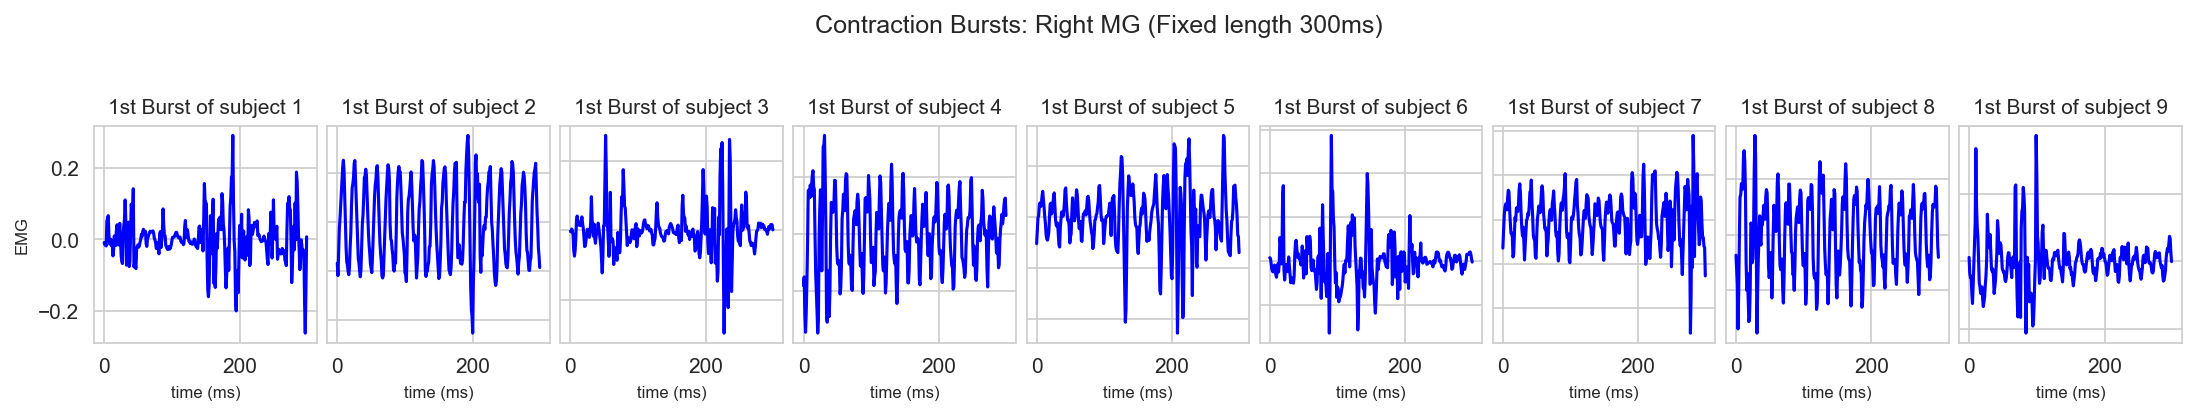

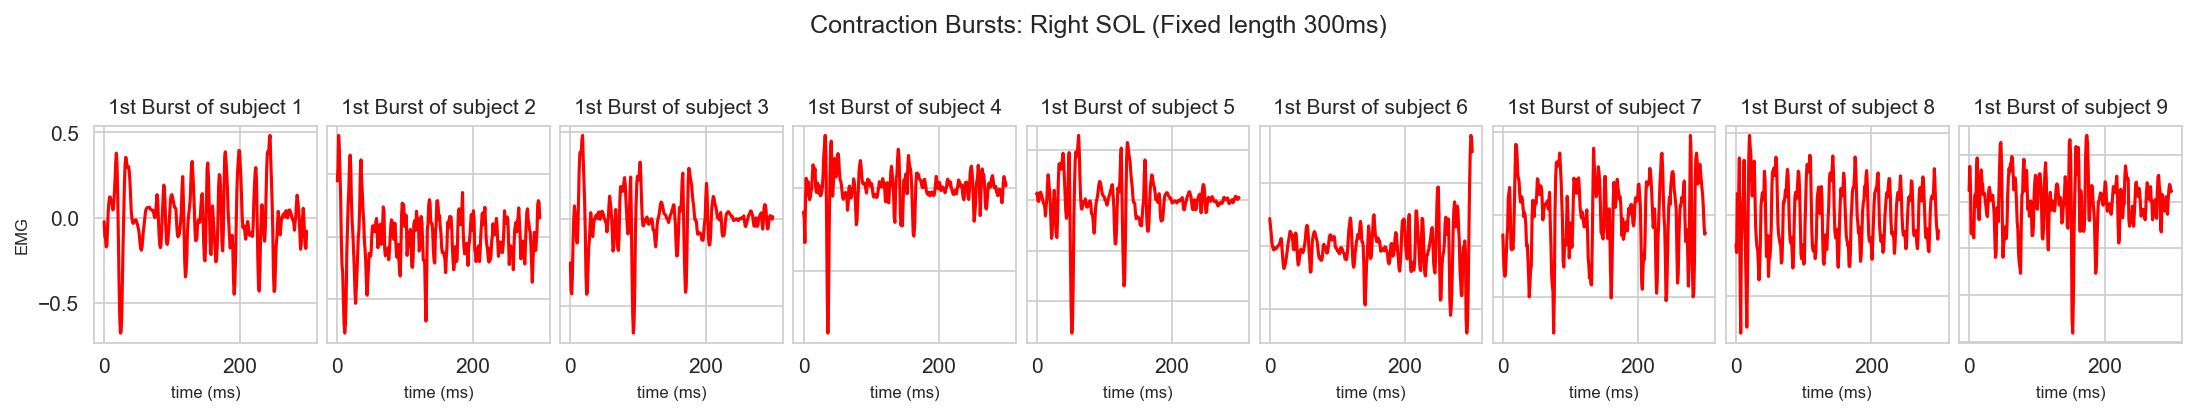

In [53]:
# quick plot to see individual contraction bursts
def plot_independent_bursts(label, burst_list, color):
    n_cols = len(burst_list)  # number of subjects
    fig, axs = plt.subplots(1, n_cols, figsize=(15, 3), dpi=150)  # Adjusted figure size
    fig.subplots_adjust(top=0.85)  # Adjust top spacing
    fig.suptitle(f'Contraction Bursts: {label} (Fixed length 300ms)', y=0.95)  # Adjust title position

    for j in range(n_cols):
        axs[j].plot(burst_list[j][0], color=color)  # Assuming you want the first burst
        axs[j].set_title(f'1st Burst of subject {j+1}', fontsize=10)
        axs[j].set_xlabel('time (ms)', fontsize=8)
        axs[j].set_ylabel('EMG', fontsize=8)
        axs[j].label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots.

    plt.tight_layout(pad=2.0, w_pad=0.5)  # Dynamically adjust layout
    plt.show()

plot_independent_bursts("Right MG", fixed_bursts_MG, "blue")
plot_independent_bursts("Right SOL", fixed_bursts_SOL, "red")

## GPU Test:

In [54]:
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available 0


In [55]:
tf.config.list_physical_devices('GPU')

[]

In [56]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [57]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [58]:
# QUICK TEST!
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# Hybrid CNN-LSTM Model Implementation

In [59]:
# Parameters
conv1D_1 = [32,5,1]  # number_filters,kernel_size and strides 
pool1D_1 = [2,2]     # pool_size and strides
conv1D_2 = [64,7,1]  # number_filters,kernel_size and strides
pool1D_2 = [2,2]     # pool_size and strides
dense_1 = 50         # nodes ->50
dense_2 = 0         # nodes -> 0
lstm_1 = 30          # lstm blocks ->30
dense_3 = 15         # nodes ->15

# Definition
model1 = Sequential()
model1.add(InputLayer((window,1))) #InputLayer(BURST_WINDOW, N_CHANNELS)

# CNN LAYER 1 (Conv1D + BatchNorm + LeakyReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_1[0],
                  kernel_size=conv1D_1[1], # TODO TRY WITH HIGHER KERNEL SIZE (ODD NUMBER!)
                  strides=conv1D_1[2],
                  padding='same',
                  name='cnn_layer_1'))
# model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(MaxPooling1D(pool_size=pool1D_1[0], strides=pool1D_1[1], padding='same'))
model1.add(Dropout(0.3))

# CNN LAYER 2 (Conv1D + BatchNorm + LeakyReLU + MaxPooling + Dropout)
model1.add(Conv1D(filters=conv1D_2[0],
                  kernel_size=conv1D_2[1],
                  strides=conv1D_2[2],
                  padding='same',
                  name='cnn_layer_2'))
# model1.add(BatchNormalization())
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(MaxPooling1D(pool_size=pool1D_2[0], strides=pool1D_2[1], padding='same'))
model1.add(Dropout(0.3))

# Dense 1
model1.add(Dense(dense_1))
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(Dropout(0.3))

# LSTM LAYER 1 + Dropout
model1.add(LSTM(lstm_1,
                dropout=0.3))

# Dense 2
model1.add(Dense(dense_3)) # We convert to Relu after LSTM blocks
model1.add(LeakyReLU(negative_slope=0.1))
model1.add(Dropout(0.3))

# Softmax
model1.add(Dense(2, 'softmax')) # Softmax
model1.summary()

# Loading Pretrained Weights
# model1.load_weights('w_cnn1.h5', by_name=True, skip_mismatch=False, options=None)
# model1.load_weights('w_cnn2.h5', by_name=True, skip_mismatch=False, options=None)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_layer_1 (Conv1D)            │ (None, 300, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 300, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_layer_2 (Conv1D)            │ (None, 150, 64)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 50)         │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 75, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            32 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,059 (109.61 KB)

 Trainable params: 28,059 (109.61 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
cp = ModelCheckpoint('model1/best_model_epoch_{epoch:02d}_val_acc_{val_accuracy:.4f}.keras', save_best_only = True)
lr = 0.001
model1.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=lr), metrics=['accuracy']) # TODO: Try DK (Learning rate)

In [61]:
# with tf.device('/gpu:0'):
history = model1.fit(train_dataset, validation_data=valid_dataset, epochs=200, callbacks=[cp])
# Retrieve minimum loss and best accuracy
min_val_categ_crossentropy = round(min(history.history['val_loss']),14)
best_val_accuracy = round(max(history.history['val_accuracy']),3)*100
# save_pickle(history, history_name+'.pkl')
history_name = f'histories/history(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})_lr[{lr}]_conv1{conv1D_1}_pool1{pool1D_1}_conv2{conv1D_2}_pool2{pool1D_2}_dense1[{dense_1}]_dense2[{dense_2}]_lstm[{lstm_1}]_dense3[{dense_3}]'
np.save(history_name + '.npy',history.history)
# NOTE: The warnings you will see in the training are not relevant (it's due to the fact that the model is being saved so to be able to call it back in the future)
print(f'History (loss and accuracy) for training and validation saved in:\n-> {history_name}')

Epoch 1/200
     10/Unknown 7s 323ms/step - accuracy: 0.5488 - loss: 0.6914

C:\Users\firas\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.5489 - loss: 0.6856 - val_accuracy: 0.5530 - val_loss: 0.5141
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - accuracy: 0.5660 - loss: 0.6782 - val_accuracy: 0.5795 - val_loss: 0.5098
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.5732 - loss: 0.6709 - val_accuracy: 0.6291 - val_loss: 0.4841
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - accuracy: 0.6377 - loss: 0.6330 - val_accuracy: 0.7099 - val_loss: 0.4127
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - accuracy: 0.6894 - loss: 0.5847 - val_accuracy: 0.7148 - val_loss: 0.4068
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.7077 - loss: 0.5477 - val_accuracy: 0.7314 - val_loss: 0.3747
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.7144 - loss: 0.5344 - val_accuracy: 0.7575 - val_loss: 0.3641
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.7363 - loss: 0.4916 - val_accuracy: 0.7603

## Plotting Loss and Accuracy Metrics over Epochs

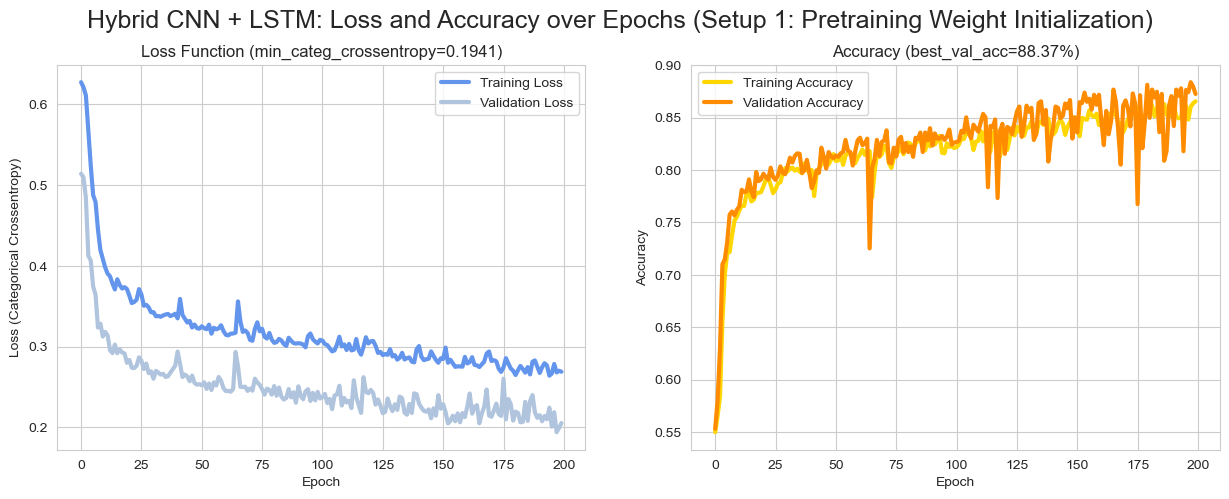

<Figure size 640x480 with 0 Axes>

In [69]:
h = np.load(history_name+'.npy',allow_pickle=True).item() ##### 'TRUE'

min_val_categ_crossentropy = round(min(h['val_loss']),4)
best_val_accuracy = round(max(h['val_accuracy']),4)*100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))
fig.suptitle('Hybrid CNN + LSTM: Loss and Accuracy over Epochs (Setup 1: Pretraining Weight Initialization)', fontsize=18, y=0.99)
ax1.set_title(f'Loss Function (min_categ_crossentropy={min_val_categ_crossentropy})')
ax2.set_title(f'Accuracy (best_val_acc={best_val_accuracy}%)')
ax1.set(xlabel='Epoch', ylabel='Loss (Categorical Crossentropy)')
ax2.set(xlabel='Epoch', ylabel='Accuracy')
ax1.plot(h['loss'], color = "cornflowerblue",linewidth=3)
ax1.plot(h['val_loss'], color = "lightsteelblue",linewidth=3)
ax1.legend(['Training Loss', 'Validation Loss'])
ax2.plot(h['accuracy'], color = "gold",linewidth=3)
ax2.plot(h['val_accuracy'], color = "darkorange",linewidth=3)
ax2.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()
plt.savefig(history_name+'.png')

model_name = f'results/NO_WEIGHTS-Hybrid_CNN-LSTM(val_acc={best_val_accuracy}%,val_categ_crossentropy={min_val_categ_crossentropy})_lr[{lr}]_conv1{conv1D_1}_pool1{pool1D_1}_conv2{conv1D_2}_pool2{pool1D_2}_dense1[{dense_1}]_dense2[{dense_2}]_lstm[{lstm_1}]_dense3[{dense_3}]'
plt.savefig(model_name+'.png')

## Serializing Datasets (train and val)

In [70]:
X_train = [] ; y_train = []
X_val = [] ; y_val = []
X_loo = [] ; y_loo = []

for feature, label in train_dataset:
    for i in range(label.shape[0]):
        X_train.append(feature[i])
        y_train.append(label[i])
for feature, label in valid_dataset:
    for i in range(label.shape[0]):
        X_val.append(feature[i])
        y_val.append(label[i])
for feature, label in loo_dataset:
    for i in range(label.shape[0]):
        X_loo.append(feature[i])
        y_loo.append(label[i])

X_train = np.array(X_train) ; y_train = np.array(y_train)
X_val = np.array(X_val) ; y_val = np.array(y_val)
X_loo = np.array(X_loo) ; y_loo = np.array(y_loo)

## Metric Functions: Confusion Matrix, Precision, Recall and F-1Score

In [74]:
model1 = load_model("model1/best_model_epoch_198_val_acc_0.8837.keras")

def plot_confusion_matrix(X,y,color,title):
    predictions_hot = model1.predict(X)
    predictions = np.argmax(predictions_hot, axis=1)
    np.set_printoptions(suppress=True)
    print("Some y Predicted\t", predictions[:30])
    y_list = np.argmax(y, axis=1)
    print("Some y Label\t\t", y_list[:30])

    cm = confusion_matrix(y_list, predictions)
    plt.figure(figsize = (15,10))
    ax = sn.heatmap(cm, annot=True, cmap=color, fmt='d')
    ax.set_title(title+'\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(["MG", "SOL"])
    ax.yaxis.set_ticklabels(["MG", "SOL"])


    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.show()

    np.set_printoptions(precision=3)
    precision, recall, f1, _ = score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1))
    f1_micro = f1_score(np.argmax(y, axis=1), np.argmax(predictions_hot, axis=1), average='micro')

    print(f'precision: {precision}')
    print(f'recall: {recall}')
    print(f'fscore: {f1}')
    print(f'fscore_micro: {f1_micro}')

## Confusion Matrix in Training

302/302 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Some y Predicted	 [1 0 0 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0]
Some y Label		 [1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0]


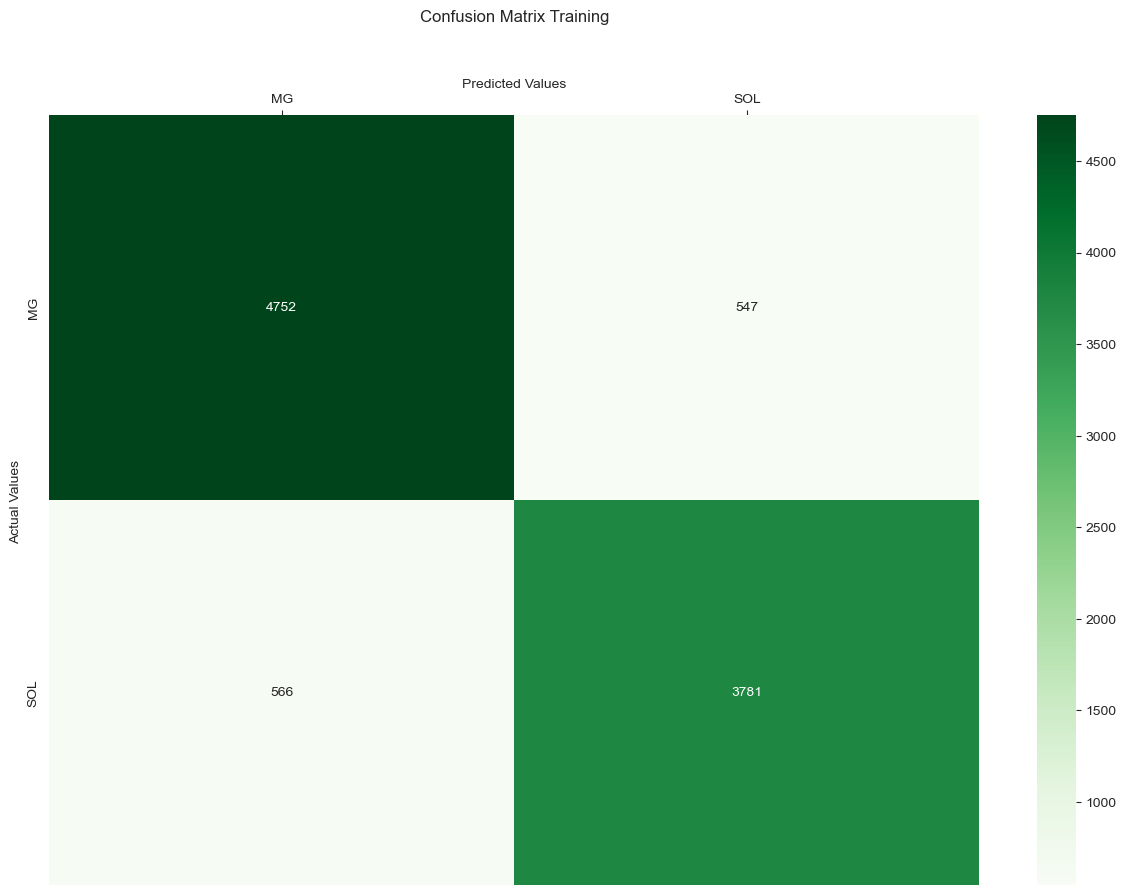

precision: [0.894 0.874]
recall: [0.897 0.87 ]
fscore: [0.895 0.872]
fscore_micro: 0.8846153846153846


In [75]:
plot_confusion_matrix(X_train, y_train, 'Greens', 'Confusion Matrix Training')

## Confusion Matrix in Testing

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Some y Predicted	 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0]
Some y Label		 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0]


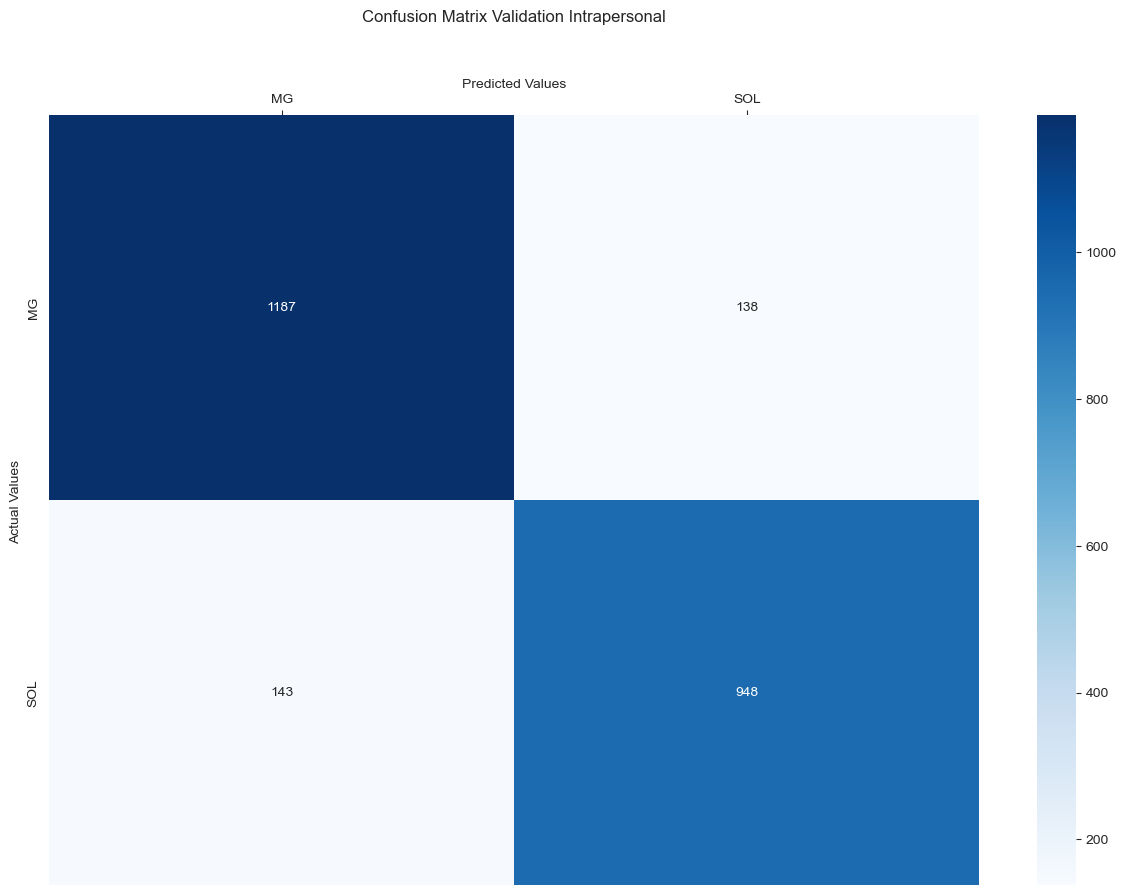

precision: [0.892 0.873]
recall: [0.896 0.869]
fscore: [0.894 0.871]
fscore_micro: 0.8836920529801324


In [76]:
plot_confusion_matrix(X_val, y_val, 'Blues', 'Confusion Matrix Validation Intrapersonal')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Some y Predicted	 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Some y Label		 [1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1]


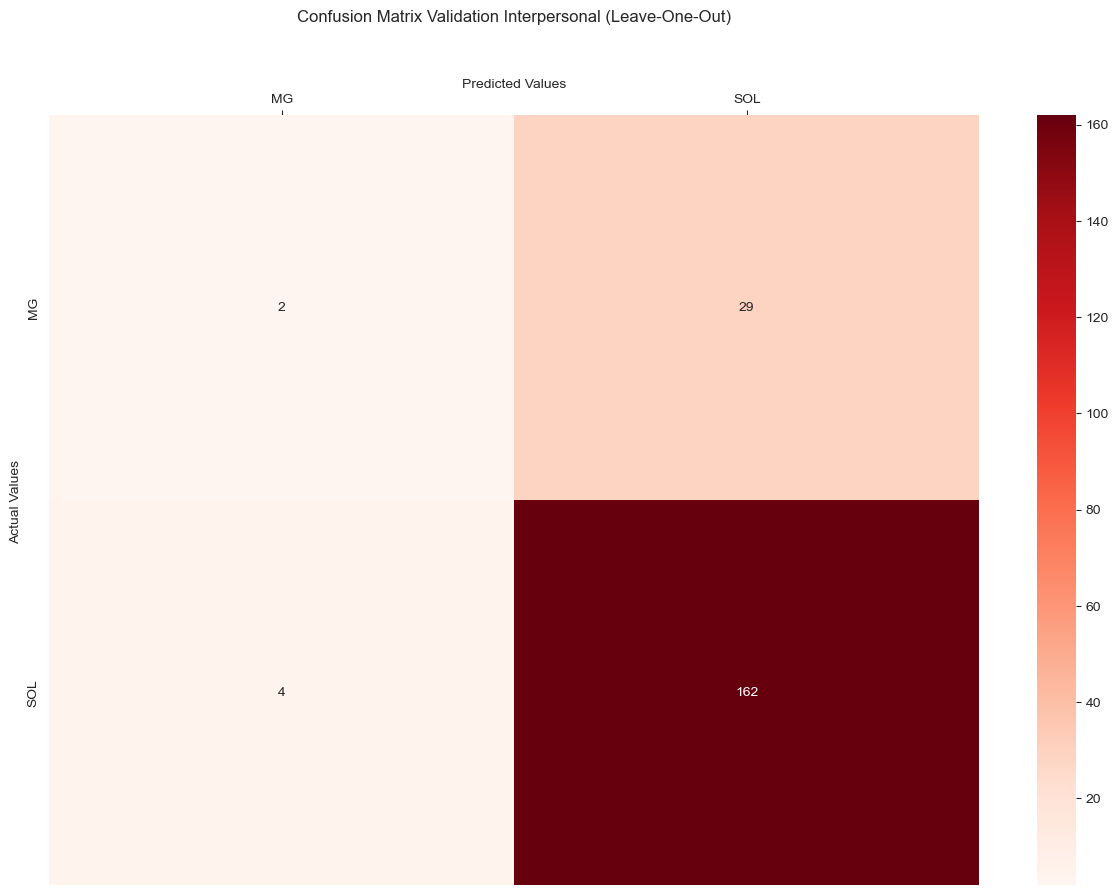

precision: [0.333 0.848]
recall: [0.065 0.976]
fscore: [0.108 0.908]
fscore_micro: 0.8324873096446701


In [77]:
plot_confusion_matrix(X_loo, y_loo, 'Reds', 'Confusion Matrix Validation Interpersonal (Leave-One-Out)')